<a href="https://colab.research.google.com/github/wayne1123/Topic/blob/master/MNIST_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --upgrade pip
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (18.1)
tcmalloc: large alloc 1073750016 bytes == 0x5c970000 @  0x7f8f55cbb2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.0
True


In [0]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=250,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=250,
                                         shuffle=False, num_workers=2)

Processing...
Done!


In [0]:
class CVAE(nn.Module):
  def __init__(self, z_dim=2):
    super(CVAE, self).__init__()
    self.e1 = nn.Linear(784+10, 512)
    self.e21 = nn.Linear(512, z_dim)
    self.e22 = nn.Linear(512, z_dim)
    self.d1 = nn.Linear(z_dim+10, 512)
    self.d2 = nn.Linear(512, 784)
    self.leakyrelu = nn.LeakyReLU(0.2)
    self.sigmoid = nn.Sigmoid()
    self.gpu = torch.cuda.is_available()
    self.merge = torch.cat

  
  def encode(self, x, y):
    #batchnorm1 = nn.BatchNorm1d(512).cuda()
    #f1 = batchnorm1(self.leakyrelu(self.e1(x)))
    f1 = self.merge([x,y],1).cuda()
    f2 = self.leakyrelu(self.e1(f1))
    f21 = self.e21(f2)
    f22 = self.e22(f2)
    return f21, f22
  
  def reparameterize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    if self.gpu:
      eps = torch.cuda.FloatTensor(std.size()).normal_()
    else:
      eps = torch.FloatTensor(std.size()).normal_()
    #eps = torch.Tensor(std.size()).normal_()
    eps = Variable(eps)
    return eps.mul(std).add_(mu)
  
  def decode(self, args):
    #batchnorm1 = nn.BatchNorm1d(512).cuda()
    #batchnorm2 = nn.BatchNorm1d(784).cuda()
    #d1 = batchnorm1(self.leakyrelu(self.d1(z)))
    #d2 = batchnorm2(self.leakyrelu(self.d2(d1)))
    #p1 = self.merge([z,y],1).cuda()
    p2 = self.leakyrelu(self.d1(args))
    p3 = self.leakyrelu(self.d2(p2))
    p4 = self.sigmoid(p3)
    return p4
    
    
  def forward(self, x, y):
    mu, logvar = self.encode(x,y)
    z = self.reparameterize(mu, logvar)
    ret = self.decode(self.merge([z,y],1))
    return ret, mu, logvar

In [0]:
cvae = CVAE().cuda()
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)

In [0]:
def one_hot_mnist(test):
  b = torch.zeros(test.shape[0],10)
  b[np.arange(test.shape[0]),test] = 1
  return b

def bce_loss(recon_x, x):
  bce = nn.BCELoss(size_average=False)
  return bce(recon_x, x)

def kl_loss(mu, logvar):
  KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
  KLD = torch.sum(KLD_element).mul_(-0.5)
  return KLD 

def mse_loss(recon_x, x):
  mse = nn.MSELoss(size_average=False)
  #bce = nn.BCEWithLogitsLoss(size_average=False)
  return mse(recon_x, x)

In [0]:
def train_cvae(model, optimizer, loss1, n_epochs, beta=1):
  for epoch in range(n_epochs):
    loss_list = []
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data
      inputs = inputs.view([-1,784])
      labels = one_hot_mnist(labels)
      inputs, labels = inputs.cuda(), labels.cuda()
      targets = inputs
      optimizer.zero_grad()
      recon_batch, mu, logvar = model(inputs,labels)
      loss = loss1(recon_batch,targets) + kl_loss(mu, logvar)*beta
      loss.backward()
      optimizer.step()
      loss_list.append([loss1(recon_batch, inputs), kl_loss(mu, logvar),
                       loss1(recon_batch,inputs)+kl_loss(mu,logvar)])
      if i % 200 == 0:
        with torch.no_grad():
          print("RL : ", loss1(recon_batch, inputs),
              " KL : ", kl_loss(mu, logvar),
             " Sum :", loss1(recon_batch,inputs)+kl_loss(mu,logvar))
  return np.array(loss_list)

In [0]:
cvae_loss = train_cvae(cvae,optimizer,bce_loss,20)

RL :  tensor(1.00000e+05 *
       1.3926, device='cuda:0')  KL :  tensor(1.9109, device='cuda:0')  Sum : tensor(1.00000e+05 *
       1.3926, device='cuda:0')
RL :  tensor(44514.8086, device='cuda:0')  KL :  tensor(2218.1460, device='cuda:0')  Sum : tensor(46732.9531, device='cuda:0')
RL :  tensor(44507.3164, device='cuda:0')  KL :  tensor(1963.5146, device='cuda:0')  Sum : tensor(46470.8320, device='cuda:0')
RL :  tensor(40472.8594, device='cuda:0')  KL :  tensor(1333.9473, device='cuda:0')  Sum : tensor(41806.8047, device='cuda:0')
RL :  tensor(39901.3828, device='cuda:0')  KL :  tensor(1352.9095, device='cuda:0')  Sum : tensor(41254.2930, device='cuda:0')
RL :  tensor(37652.9609, device='cuda:0')  KL :  tensor(1193.0359, device='cuda:0')  Sum : tensor(38845.9961, device='cuda:0')
RL :  tensor(37862.0508, device='cuda:0')  KL :  tensor(1143.6908, device='cuda:0')  Sum : tensor(39005.7422, device='cuda:0')
RL :  tensor(37093.8438, device='cuda:0')  KL :  tensor(1119.5432, device='cuda:

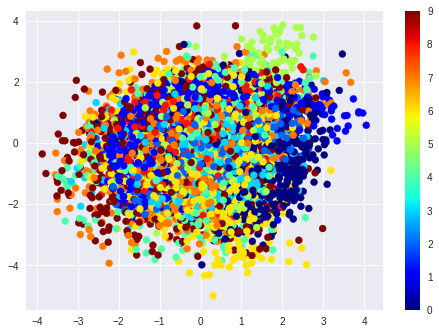

In [0]:
def get_z_value(model):
  encode_total = torch.empty(10000,2)
  label_total = torch.empty(10000,)
  with torch.no_grad():
    for i, data in enumerate(testloader,0):
      images, labels_o = data
      images, labels = images.reshape(-1,784), one_hot_mnist(labels_o)
      images, labels = images.cuda(), labels.cuda()
      z_mu, _ = model.encode(images, labels)
      encode_total[250*i:250*(i+1)] = z_mu
      label_total[250*i:250*(i+1)] = labels_o.cuda()
  label_total = label_total.int()
  plt.scatter(encode_total[:,0],encode_total[:,1],c=label_total, cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()
  return encode_total, label_total

z_mu_cvae, y_cvae = get_z_value(cvae)

In [0]:
def construct_numvec(digit, z = None):
    n_z, n_y = 2, 10
    digit = torch.tensor(digit).int()
    out = torch.zeros((1, n_z + n_y))
    out[:, digit + n_z] = 1.
    if z is None:
        return out
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return out

In [0]:
a = torch.tensor(-1.5)
b = torch.tensor(-1.5)
c = torch.stack([a,b],0)

In [0]:
def explore_latent_cvae(model):
  sides = 8
  max_z = 1.5
  img_it = 0
  with torch.no_grad():
    for dig in range(10):
      print(dig)
      img_it = 0
      for i in range(0, sides):
        z1 = (((i / (sides-1)) * max_z)*2) - max_z
        for j in range(0, sides):
          z2 = (((j / (sides-1)) * max_z)*2) - max_z
        #print(z1,z2)
          z_ = torch.tensor([z1, z2])
          #print(z_.shape)
        #print(z_)
          vec = construct_numvec(dig,z_).cuda()
          #print(vec.shape)
          decoded = model.decode(vec)
          plt.subplot(sides, sides, 1 + img_it)
          img_it +=1
          decoded = decoded.detach()
          plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray)
          plt.axis('off')
      plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
      plt.show()
  

0


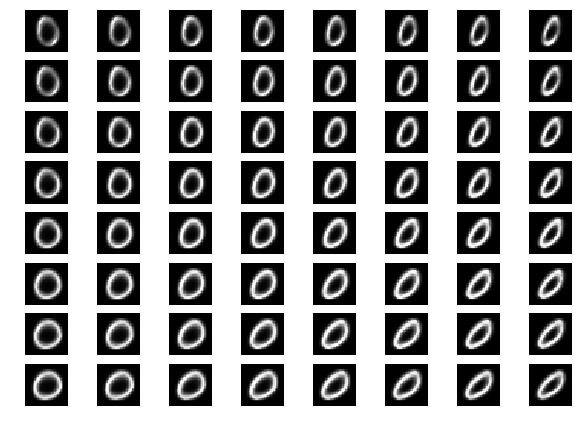

1


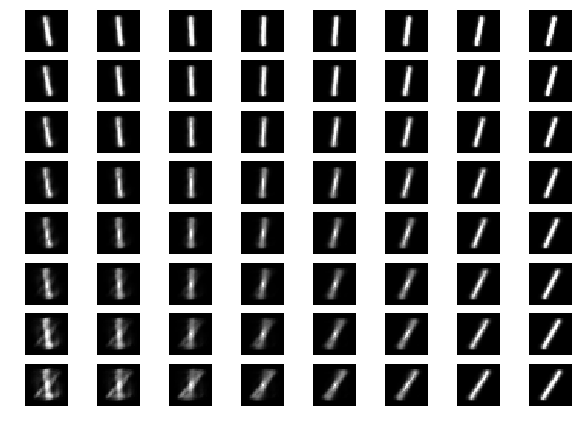

2


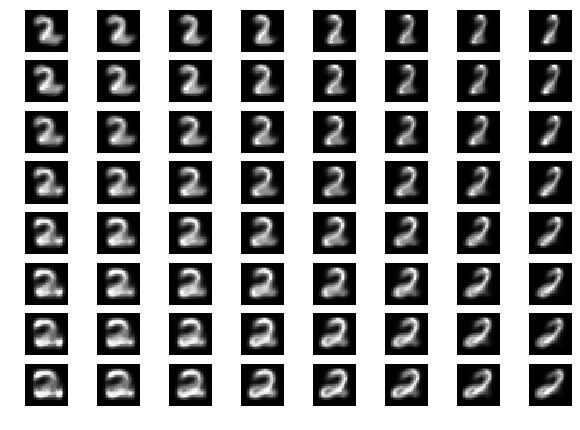

3


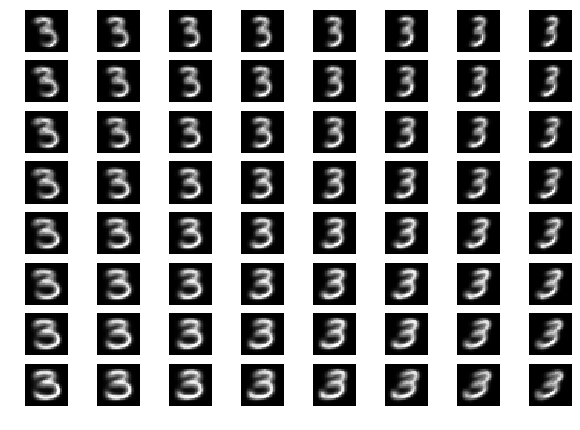

4


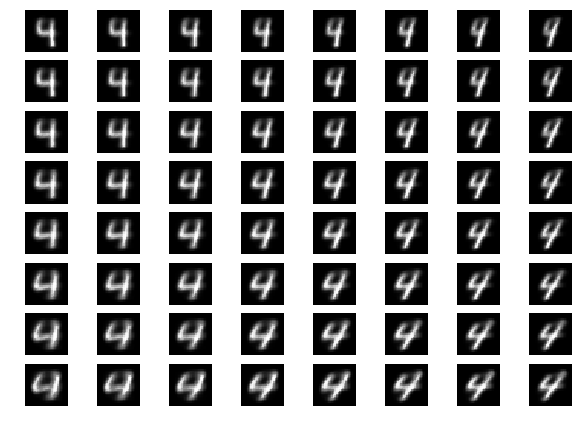

5


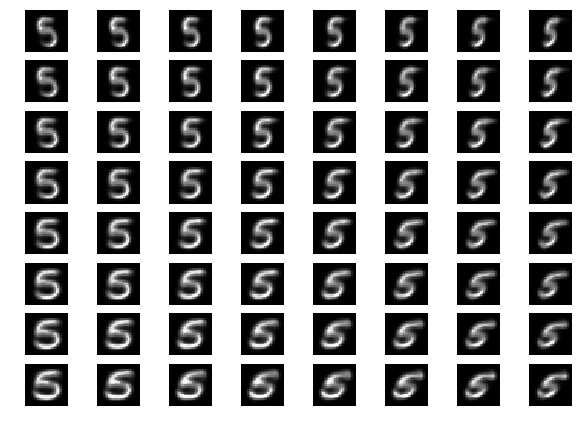

6


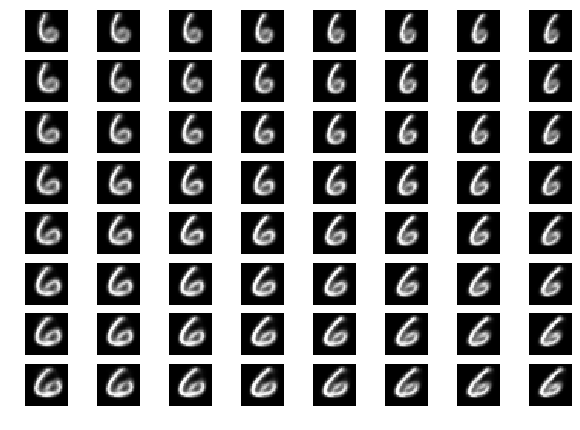

7


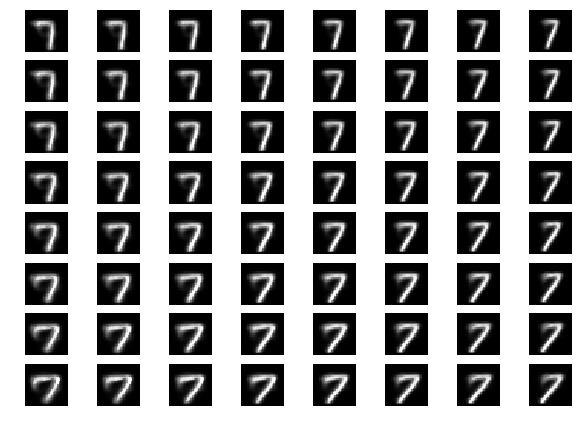

8


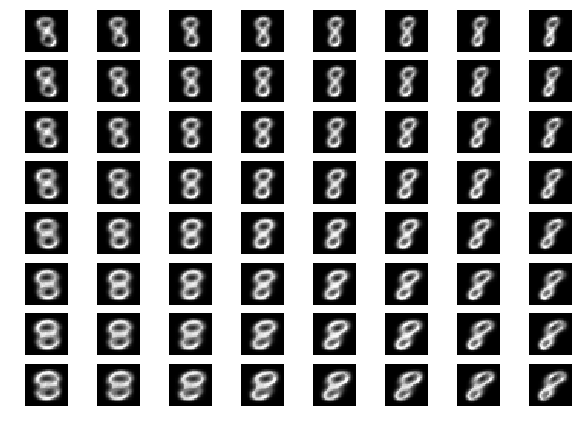

9


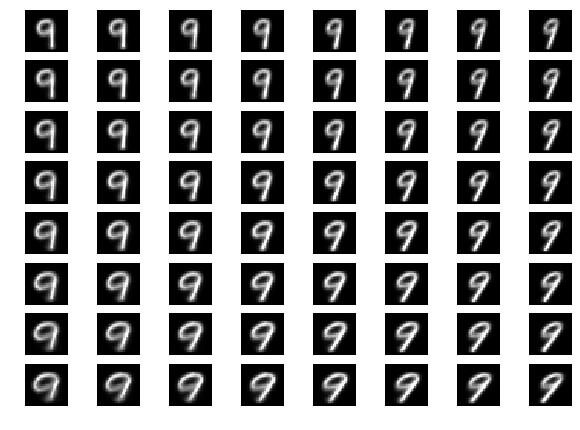

In [0]:
explore_latent_cvae(cvae)

In [0]:
z_new = torch.randn(2,)
newvec= construct_numvec(3,z_new) + construct_numvec(6)

In [0]:
print(newvec)

tensor([[ 0.4929,  0.6773,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000]])


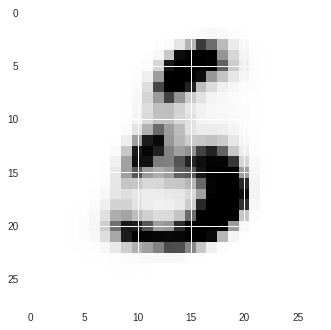

In [0]:
with torch.no_grad():
  z_new_ = newvec.cuda()
  decoded_2 = cvae.decode(z_new_)
  decoded_2 = decoded_2.detach()
  plt.imshow(decoded_2.reshape(28,28))
  plt.show()

In [0]:
class VAE(nn.Module):
  def __init__(self, z_dim=2):
    super(VAE, self).__init__()
    self.e1 = nn.Linear(784, 512)
    self.e21 = nn.Linear(512, z_dim)
    self.e22 = nn.Linear(512, z_dim)
    self.d1 = nn.Linear(z_dim, 512)
    self.d2 = nn.Linear(512, 784)
    self.leakyrelu = nn.LeakyReLU(0.2)
    self.sigmoid = nn.Sigmoid()
    self.gpu = torch.cuda.is_available()
    self.merge = torch.cat

  
  def encode(self, x):
    #batchnorm1 = nn.BatchNorm1d(512).cuda()
    #f1 = batchnorm1(self.leakyrelu(self.e1(x)))
    f1 = self.leakyrelu(self.e1(x))
    f21 = self.e21(f1)
    f22 = self.e22(f1)
    return f21, f22
  
  def reparameterize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    if self.gpu:
      eps = torch.cuda.FloatTensor(std.size()).normal_()
    else:
      eps = torch.FloatTensor(std.size()).normal_()
    #eps = torch.Tensor(std.size()).normal_()
    eps = Variable(eps)
    return eps.mul(std).add_(mu)
  
  def decode(self, args):
    #batchnorm1 = nn.BatchNorm1d(512).cuda()
    #batchnorm2 = nn.BatchNorm1d(784).cuda()
    #d1 = batchnorm1(self.leakyrelu(self.d1(z)))
    #d2 = batchnorm2(self.leakyrelu(self.d2(d1)))
    #p1 = self.merge([z,y],1).cuda()
    p2 = self.leakyrelu(self.d1(args))
    p3 = self.leakyrelu(self.d2(p2))
    p4 = self.sigmoid(p3)
    return p4
    
    
  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    ret = self.decode(z)
    return ret, mu, logvar

In [0]:
vae = VAE().cuda()
optim_vae = optim.Adam(vae.parameters(), lr=1e-3)

In [0]:
def train_vae(model, optimizer, loss1, n_epochs, beta=1):
  for epoch in range(n_epochs):
    loss_list = []
    for i, data in enumerate(trainloader, 0):
      inputs, _ = data
      inputs = inputs.view([-1,784])
      inputs = inputs.cuda()
      targets = inputs
      optimizer.zero_grad()
      recon_batch, mu, logvar = model(inputs)
      loss = loss1(recon_batch,targets) + kl_loss(mu, logvar)*beta
      loss.backward()
      optimizer.step()
      loss_list.append([loss1(recon_batch, inputs), kl_loss(mu, logvar),
                       loss1(recon_batch,inputs)+kl_loss(mu,logvar)])
      if i % 200 == 0:
        with torch.no_grad():
          print("RL : ", loss1(recon_batch, inputs),
              " KL : ", kl_loss(mu, logvar),
             " Sum :", loss1(recon_batch,inputs)+kl_loss(mu,logvar))
  return np.array(loss_list)

In [0]:
vae_loss = train_vae(vae, optim_vae, bce_loss, 20)

RL :  tensor(1.00000e+05 *
       1.4238, device='cuda:0')  KL :  tensor(5.5588, device='cuda:0')  Sum : tensor(1.00000e+05 *
       1.4239, device='cuda:0')
RL :  tensor(47519.1172, device='cuda:0')  KL :  tensor(2405.7859, device='cuda:0')  Sum : tensor(49924.9023, device='cuda:0')
RL :  tensor(46729.6758, device='cuda:0')  KL :  tensor(2148.3657, device='cuda:0')  Sum : tensor(48878.0430, device='cuda:0')
RL :  tensor(46184.4766, device='cuda:0')  KL :  tensor(1645.1880, device='cuda:0')  Sum : tensor(47829.6641, device='cuda:0')
RL :  tensor(45302.3906, device='cuda:0')  KL :  tensor(1573.3518, device='cuda:0')  Sum : tensor(46875.7422, device='cuda:0')
RL :  tensor(45355.4414, device='cuda:0')  KL :  tensor(1418.4073, device='cuda:0')  Sum : tensor(46773.8477, device='cuda:0')
RL :  tensor(45128.5195, device='cuda:0')  KL :  tensor(1475.8757, device='cuda:0')  Sum : tensor(46604.3945, device='cuda:0')
RL :  tensor(43282.9922, device='cuda:0')  KL :  tensor(1396.4440, device='cuda:

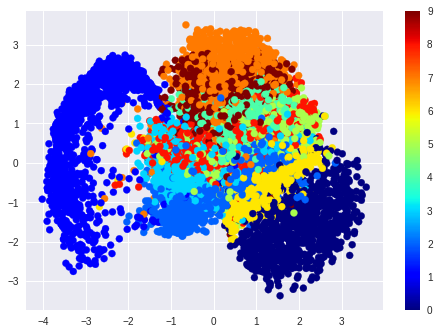

In [0]:
def get_z_value_vae(model):
  encode_total = torch.empty(10000,2)
  label_total = torch.empty(10000,)
  with torch.no_grad():
    for i, data in enumerate(testloader,0):
      images, labels_o = data
      images, labels = images.reshape(-1,784), one_hot_mnist(labels_o)
      images, labels = images.cuda(), labels.cuda()
      z_mu, _ = model.encode(images)
      encode_total[250*i:250*(i+1)] = z_mu
      label_total[250*i:250*(i+1)] = labels_o.cuda()
  label_total = label_total.int()
  plt.scatter(encode_total[:,0],encode_total[:,1],c=label_total, cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()
  return encode_total, label_total

z_mu_vae, y_vae = get_z_value_vae(vae)

In [0]:
def explore_latent_vae(model):
  sides = 8
  max_z = 1.5
  img_it = 0
  with torch.no_grad():
      img_it = 0
      for i in range(0, sides):
        z1 = (((i / (sides-1)) * max_z)*2) - max_z
        for j in range(0, sides):
          z2 = (((j / (sides-1)) * max_z)*2) - max_z
        #print(z1,z2)
          z_ = torch.tensor([z1, z2])
          #print(z_.shape)
        #print(z_)
          #print(vec.shape)
          z_ = z_.cuda()
          decoded = model.decode(z_)
          plt.subplot(sides, sides, 1 + img_it)
          img_it +=1
          decoded = decoded.detach()
          plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray)
          plt.axis('off')
      plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
      plt.show()

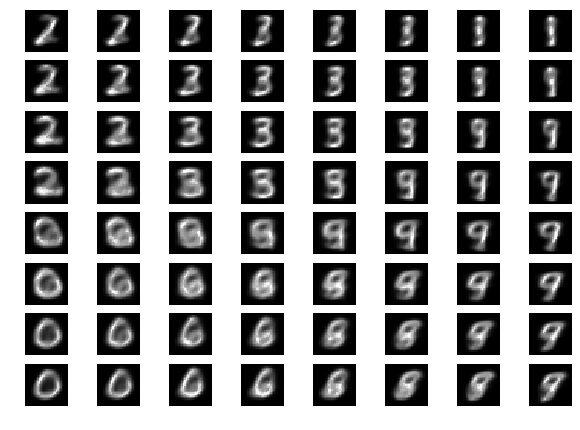

In [0]:
explore_latent_vae(vae)